In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Quedsten/Plant-Health-Classification/refs/heads/main/plant_health_data.csv')

In [ ]:
df.drop('Plant_ID', axis=1, inplace=True)
df.drop('Timestamp', axis=1, inplace=True)

In [ ]:
df.head()

,Soil_Moisture,Ambient_Temperature,Soil_Temperature,Humidity,Light_Intensity,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Chlorophyll_Content,Electrochemical_Signal,Plant_Health_Status
0,27.521109,22.240245,21.900435,55.291904,556.172805,5.581955,10.003650,45.806852,39.076199,35.703006,0.941402,High Stress
1,14.835566,21.706763,18.680892,63.949181,596.136721,7.135705,30.712562,25.394393,17.944826,27.993296,0.164899,High Stress
2,17.086362,21.180946,15.392939,67.837956,591.124627,5.656852,29.337002,27.573892,35.706530,43.646308,1.081728,High Stress
3,15.336156,22.593302,22.778394,58.190811,241.412476,5.584523,16.966621,26.180705,26.257746,37.838095,1.186088,High Stress
4,39.822216,28.929001,18.100937,63.772036,444.493830,5.919707,10.944961,37.898907,37.654483,48.265812,1.609805,High Stress


In [ ]:
X = df[['Soil_Moisture',	'Ambient_Temperature',	'Soil_Temperature',	'Humidity',	'Light_Intensity',	'Soil_pH',	'Nitrogen_Level',	'Phosphorus_Level',	'Potassium_Level',	'Chlorophyll_Content', 'Electrochemical_Signal']].values
y = df['Plant_Health_Status'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

In [ ]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
with open('scaler.pk1', 'wb') as f:
  pickle.dump(sc, f)


In [ ]:
classifiers = {
    'SVM (linear)': SVC(kernel='linear', probability=True, random_state=42),
    'SVM (rbf)': SVC(kernel='rbf', probability=True, random_state=42),
    'SVM (poly)': SVC(kernel='poly', probability=True, random_state=42),
    'SVM (sigmoid)': SVC(kernel='sigmoid', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}


In [ ]:
def perform_cv(X, y, classifier, cv_type='regular', n_splits=5):
    if cv_type == 'regular':
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    else:
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores = []
    for train_index, val_index in kf.split(X, y):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        classifier.fit(X_train_fold, y_train_fold)
        scores.append(classifier.score(X_val_fold, y_val_fold))

    return np.mean(scores)

In [ ]:
def plot_model_metrics_comparison(y_true, predictions_dict):
    metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    model_names = list(predictions_dict.keys())

    for model_name, y_pred in predictions_dict.items():
        metrics['Accuracy'].append(accuracy_score(y_true, y_pred))
        metrics['Precision'].append(precision_score(y_true, y_pred, average='weighted'))
        metrics['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
        metrics['F1'].append(f1_score(y_true, y_pred, average='weighted'))

    fig, ax = plt.subplots(figsize=(12, 6))

    barWidth = 0.15
    r1 = np.arange(len(model_names))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    plt.bar(r1, metrics['Accuracy'], width=barWidth, label='Accuracy', color='#1f77b4')
    plt.bar(r2, metrics['Precision'], width=barWidth, label='Precision', color='#ff7f0e')
    plt.bar(r3, metrics['Recall'], width=barWidth, label='Recall', color='#2ca02c')
    plt.bar(r4, metrics['F1'], width=barWidth, label='F1', color='#d62728')

    plt.xlabel('Model')
    plt.ylabel('Weighted Avg')
    plt.title('Model vs Weighted Avg Of Various Metrics')

    plt.xticks([r + barWidth*1.5 for r in range(len(model_names))], model_names)
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

In [ ]:
cv_scores = {}
predictions_dict = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")

    regular_cv_score = perform_cv(X_train_scaled, y_train, clf, 'regular')
    stratified_cv_score = perform_cv(X_train_scaled, y_train, clf, 'stratified')

    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    short_name = name.split()[0] if len(name.split()) > 1 else name
    predictions_dict[short_name] = y_pred

    with open(f'{name.lower().replace(" ", "_")}.pk1', 'wb') as f:
        pickle.dump(clf, f)

    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"Regular CV Score: {regular_cv_score:.4f}")
    print(f"Stratified CV Score: {stratified_cv_score:.4f}")

    cv_scores[name] = {
        'regular': regular_cv_score,
        'stratified': stratified_cv_score
    }


Training SVM (linear)...

Classification Report for SVM (linear):
                 precision    recall  f1-score   support

        Healthy       0.74      0.87      0.80        91
    High Stress       0.86      0.79      0.82       154
Moderate Stress       0.70      0.69      0.69       115

       accuracy                           0.78       360
      macro avg       0.77      0.78      0.77       360
   weighted avg       0.78      0.78      0.78       360

Regular CV Score: 0.7881
Stratified CV Score: 0.7857

Training SVM (rbf)...

Classification Report for SVM (rbf):
                 precision    recall  f1-score   support

        Healthy       0.81      0.80      0.81        91
    High Stress       0.88      0.87      0.87       154
Moderate Stress       0.70      0.71      0.71       115

       accuracy                           0.80       360
      macro avg       0.80      0.80      0.80       360
   weighted avg       0.80      0.80      0.80       360

Regular CV Scor

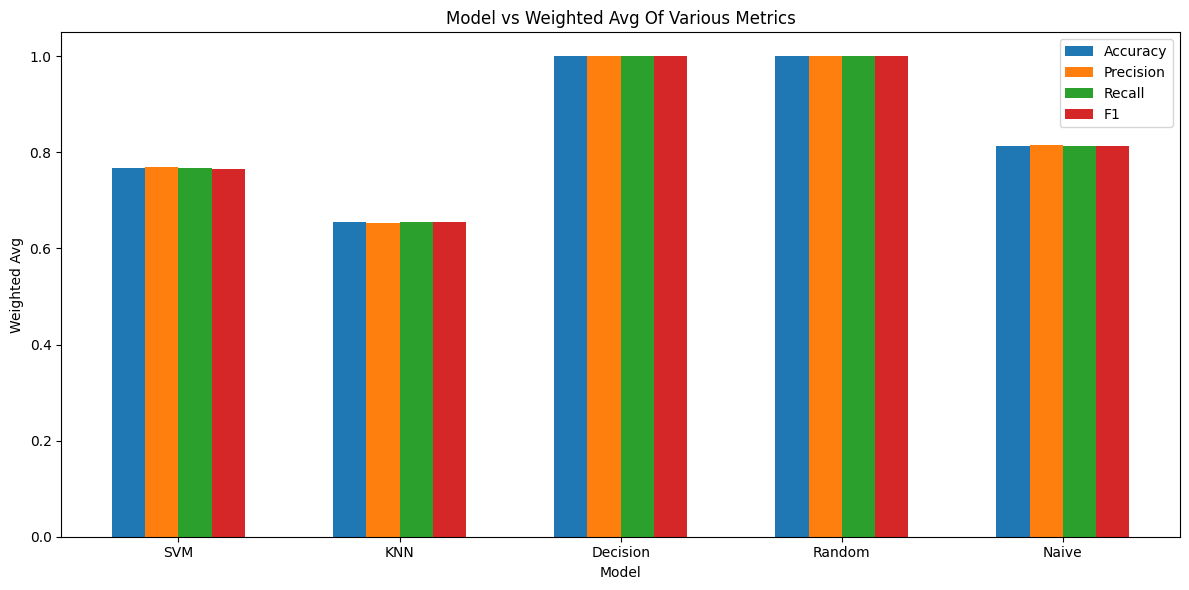

In [ ]:
plot_model_metrics_comparison(y_test, predictions_dict)

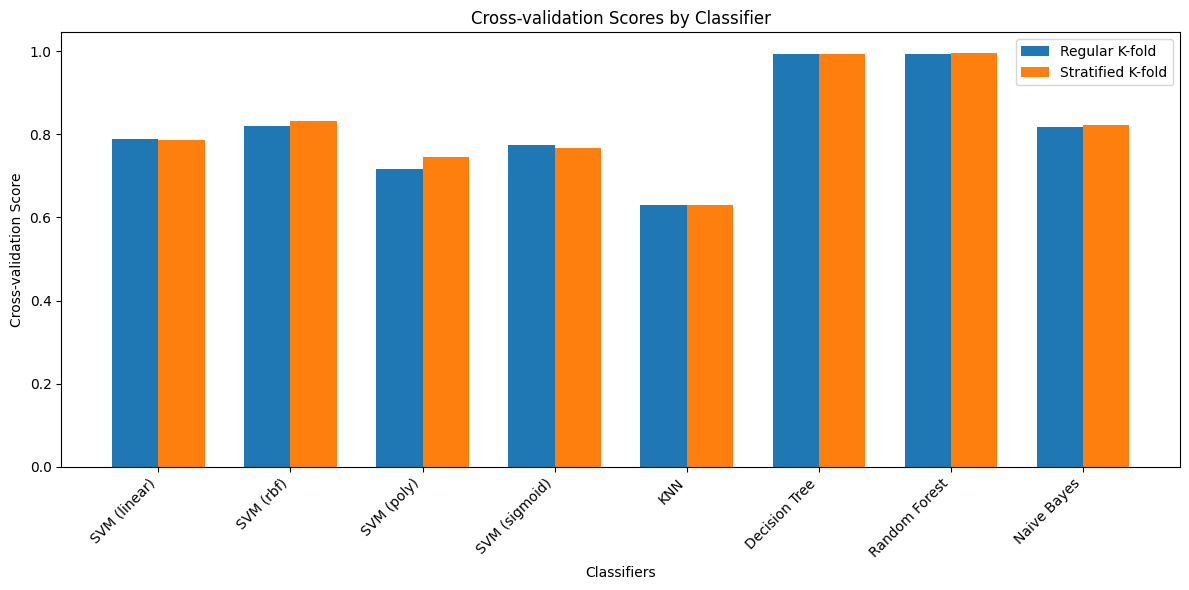

In [ ]:
plt.figure(figsize=(12, 6))
x = np.arange(len(classifiers))
width = 0.35

plt.bar(x - width/2, [scores['regular'] for scores in cv_scores.values()], width,
        label='Regular K-fold')
plt.bar(x + width/2, [scores['stratified'] for scores in cv_scores.values()], width,
        label='Stratified K-fold')

plt.xlabel('Classifiers')
plt.ylabel('Cross-validation Score')
plt.title('Cross-validation Scores by Classifier')
plt.xticks(x, classifiers.keys(), rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

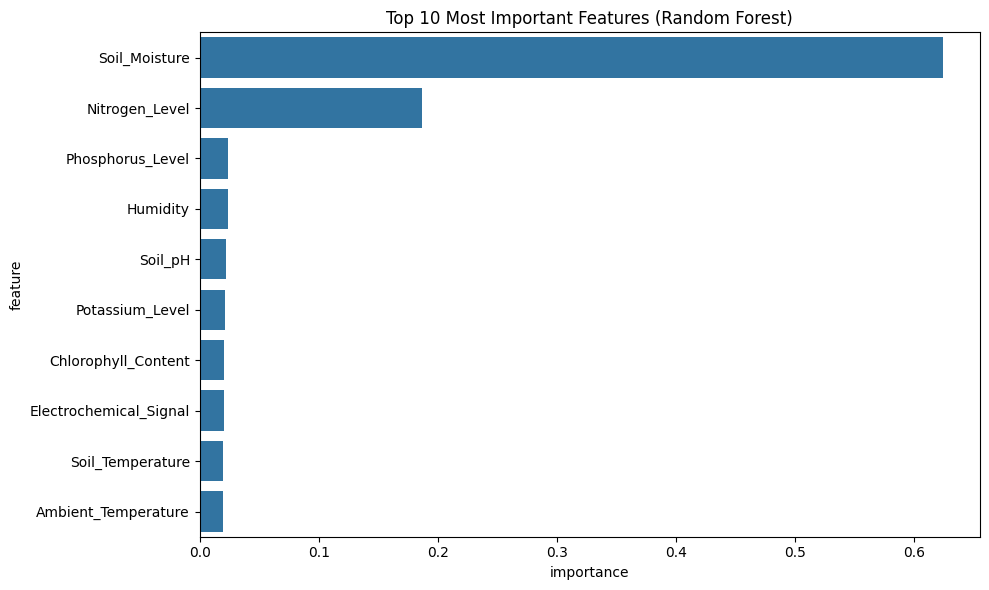

In [ ]:
rf_clf = classifiers['Random Forest']
feature_importance = pd.DataFrame({
    'feature': df[['Soil_Moisture',	'Ambient_Temperature',	'Soil_Temperature',	'Humidity',	'Light_Intensity',	'Soil_pH',	'Nitrogen_Level',	'Phosphorus_Level',	'Potassium_Level',	'Chlorophyll_Content', 'Electrochemical_Signal']].columns,
    'importance': rf_clf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 10 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

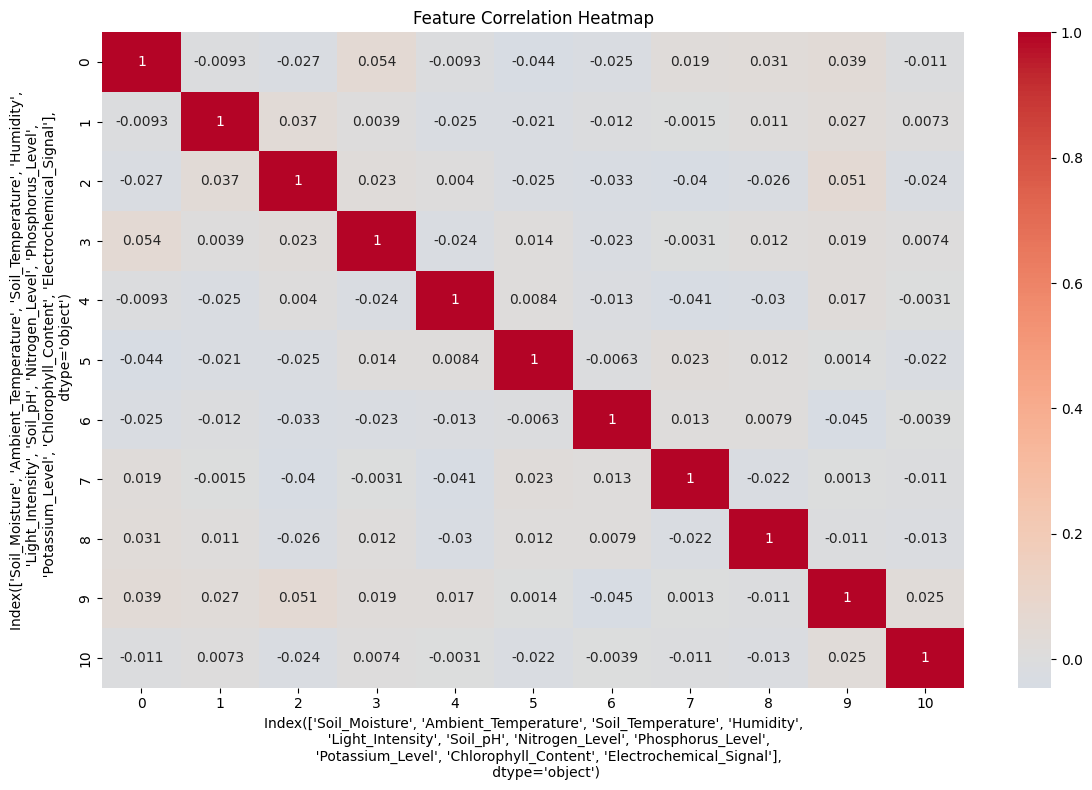

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(X).corr(), annot=True, cmap='coolwarm', center=0)
plt.xlabel(df[['Soil_Moisture', 'Ambient_Temperature',  'Soil_Temperature', 'Humidity', 'Light_Intensity',  'Soil_pH',  'Nitrogen_Level',   'Phosphorus_Level', 'Potassium_Level',  'Chlorophyll_Content', 'Electrochemical_Signal']].columns)
plt.ylabel(df[['Soil_Moisture', 'Ambient_Temperature',  'Soil_Temperature', 'Humidity', 'Light_Intensity',  'Soil_pH',  'Nitrogen_Level',   'Phosphorus_Level', 'Potassium_Level',  'Chlorophyll_Content', 'Electrochemical_Signal']].columns)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [ ]:
import sklearn
print(sklearn.__version__)

1.6.0
